# MARS5001 Coastal Processes and Systems 


# NB2 - Beach Profile Evolution

# Overview

<img src=http://oss.deltares.nl/documents/401440/401853/XBeach.png>

<p>Ok, we've seen how to write a simple model of shallow water equations ( **SWE** ). We will learn how to use an open-source model <a href:'http://oss.deltares.nl/web/xbeach/home'>XBeach</a> developed by <a href:'http://www.deltares.nl/en'>Deltares</a> to perform more complex simulations.</p> 
<br/>
<br/>
<small>
**Acknowlegement** &mdash; This notebook  is illustrated base on the XBeach *Default* example available on the code <a href:'http://oss.deltares.nl/web/xbeach/documentation'>webpage</a>.
</small>

# IPython Modules

<p>Python has a way to put definitions in a file and use them in a script or in an interactive instance of the interpreter. Such a file is called a **module**; definitions from a module can be imported into other modules or into the main module (the collection of variables that you have access to in a script executed at the top level and in calculator mode).</p>

<p>For this notebook I have created a module which contains a list of shell commands that we will use later on...</p>

---
Here is the file:

In [10]:
# name: myOSshell.py
# type: text/x-python-script
# size: 1581 bytes 
 
##########################################################
# Some usefull shell command for the MARS5001 lectures
# Author: Tristan Salles
# Date: 13/03/15
##########################################################
import glob
import os
from distutils.dir_util import mkpath

# Running XBeach model
def xbeach_command(DIR):
    # Get the current working directory
    working_path=os.getcwd()
    # Prepare the shell command
    run_xbeach='(cd '+working_path+'/'+DIR+'; xbeach)'
    # run XBEACH
    os.system(run_xbeach)

# Upload to dropbox
def dropbox_upload(OUTDIR,OUTFILE,UPLOADDIR):
    # Get the current working directory
    working_path=os.getcwd()
    # Prepare the shell command
    dropbox_upload='(~/Dropbox-Uploader/dropbox_uploader.sh upload '+working_path+'/'+OUTDIR+'/'+OUTFILE+' '+UPLOADDIR+')'
    # upload file to dropbox
    os.system(dropbox_upload)

# Download from dropbox
def dropbox_download(REMOTE,LOCALDIR,LOCALFILE):
    # Get the current working directory
    working_path=os.getcwd()
    # Prepare the shell command
    dropbox_download='(~/Dropbox-Uploader/dropbox_uploader.sh download '+REMOTE+' '+working_path+'/'+OUTDIR+'/'+OUTFILE+')'
    # download file from dropbox
    os.system(dropbox_download)

# List specific directory
def list_dir(DIR):  
    print glob.glob(DIR+'/*')

# Delete a file or a folder
def delete(NAME):
    # Get the current working directory
    working_path=os.getcwd()
    delete_os='(rm -r '+working_path+'/'+NAME+')'
    # run RM
    os.system(delete_os)

# Copy a file or a folder
def copy(NAME,PLACE):
    # Get the current working directory
    working_path=os.getcwd()
    copy_os='(cp -r '+working_path+'/'+NAME+' '+PLACE+')'
    # run CP
    os.system(copy_os)

# Create a folder
def mkdir(DIR):
    mkpath('./'+DIR)

## Using the created module

<p>Once compiled with python:</p>
<code>python myOSshell.py</code>
<br/>
<p>we can import it as other Python modules</p>
<code>import myOSshell</code>
<br/>
<p>And then use the defined commands.</p>

In [11]:
import myOSshell as myos

# Delete a directory
myos.delete('tristan1')
# Create a directory
myos.mkdir('./tristan1')
# List files/directories from my location
myos.list_dir('.')
# List files/directories from another location
myos.list_dir('./XBeach1')
# Copy from one directory to another one
myos.copy('./XBeach1/*','./tristan1/')
# List created directory files
myos.list_dir('./tristan1')

['./myOSshell.pyc', './NB1-SWE1D.ipynb', './NB2-BeachProfileDefault.ipynb', './XBeach1', './tristan2', './myOSshell.py', './NB3-myBeachProfile.ipynb', './Lecture-overview.ipynb', './tristan1']
['./XBeach1/y.grd', './XBeach1/params.txt', './XBeach1/x.grd', './XBeach1/bed.dep', './XBeach1/jonswap.txt']
['./tristan1/y.grd', './tristan1/params.txt', './tristan1/x.grd', './tristan1/bed.dep', './tristan1/jonswap.txt']


In [13]:
%pylab inline
%matplotlib inline
import os
import glob
import netCDF4
import subprocess
import numpy as np
import matplotlib.tri as Tri
import myOSshell  as myos
import matplotlib.pyplot as plt
from matplotlib import animation
from distutils.dir_util import mkpath
from JSAnimation import IPython_display

Populating the interactive namespace from numpy and matplotlib


# XBeach

XBeach is a two-dimensional model for:

+ wave propagation, 
+ long waves and mean flow, 
+ sediment transport and morphological changes of the nearshore area, beaches, dunes and backbarrier during storms. 

If you really want to play with XBeach I will strongly recommend to download the manual from <a href='http://oss.deltares.nl/web/xbeach/manuals/-/document_library_display/tX5e/view/49476/3202?_110_INSTANCE_tX5e_redirect=http%3A%2F%2Foss.deltares.nl%2Fweb%2Fxbeach%2Fmanuals%3Fp_p_id%3D110_INSTANCE_tX5e%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26p_p_col_id%3Dcolumn-2%26p_p_col_pos%3D1%26p_p_col_count%3D2'> here </a>.

In [14]:
from IPython.core.display import HTML
HTML('<iframe src=https://publicwiki.deltares.nl/download/thumbnails/42401924/vaklodingen_haringvlietmonding%5B1%5D.jpg width=300 height=220 name="left"></iframe>'
    '<iframe src=https://publicwiki.deltares.nl/download/thumbnails/42401924/ahn_vaklodingen.jpg width=300 height=220 name="center"></iframe>'
    '<iframe src=https://publicwiki.deltares.nl/download/thumbnails/42401924/vaklodingen2.jpg width=300 height=220 name="right"></iframe>')

It is a public-domain model that has been developed with major funding from: 

+ the US Army Corps of Engineers, 
+ Rijkswaterstaat and the EU, 
+ supported by a consortium of UNESCO-IHE, Deltares, 
+ Delft University of Technology and 
+ the University of Miami. 

# XBeach input files

<img src='http://www.dsd-int.nl/wp-content/uploads/2014/05/copy-banner-DSD-2014-international-v2-e1399537594549.jpg', width=1000>

XBeach is a numerical model of nearshore processes intended as a tool to compute the natural coastal response during time-varying storm and hurricane conditions, including dune erosion, overwash and breaching.

In [15]:
from IPython.display import YouTubeVideo
# XBeach Hydrostatic / Surf beat vs XBeach Non-hydrostatic.
YouTubeVideo('UgK2OfaNqfM')

# Description of the main inputs

For this first example we will use the *Default* input file that we have just copied in the folder you've just created. 

In [16]:
%ls

Lecture-overview.ipynb  myOSshell.pyc    NB2-BeachProfileDefault.ipynb  tristan1/  XBeach1/
myOSshell.py            NB1-SWE1D.ipynb  NB3-myBeachProfile.ipynb       tristan2/


Let us have a look at what is inside this folder:

In [17]:
myos.list_dir('tristan1')

['tristan1/y.grd', 'tristan1/params.txt', 'tristan1/x.grd', 'tristan1/bed.dep', 'tristan1/jonswap.txt']


The input files to run the model are:

+ x.grd: space discretisation along x-axis
+ y.grd: space discretisation along y-axis
+ bed.dep: seabed elevation
+ jonswap: spectral wave parameters
+ params.txt: parameters file for xbeach

The *params.txt* file is required to run the XBeach model and the program is going to look specifically for this name in your directory so you cannot change its name! Let us have a look at how this file is formated:

In [18]:
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% XBeach parameter settings input file                       %%%
%%%                                                                                                          %%%
%%% date:     9-Sep-2011 9:45:52                                           %%%
%%% function: xb_write_params                                              %%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%% Grid parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

depfile   = bed.dep
posdwn    = 0
nx        = 230
ny        = 0
alfa      = 0
vardx     = 1
xfile     = x.grd
yfile     = y.grd
xori      = 0
yori      = 0
thetamin  = 225
thetamax  = 315
dtheta    = 90
thetanaut = 1

%%% Initial conditions %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

zs0       = 5

%%% Model time %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

tstop     = 2250

%%% Morphology parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

morstart  = 250

%%% Wave boundary condition parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

instat    = jons

%%% Wave-spectrum boundary condition parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

bcfile    = jonswap.txt
rt        = 1800
dtbc      = 1

%%% Output variables %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
outputformat = netcdf
tstart    = 250

ERROR: Cell magic `%%` not found.


**A good starting point for Ocean Wave Theory is the online chapter from <a href:'http://oceanworld.tamu.edu/resources/ocng_textbook/chapter16/chapter16_01.htm'> Texas A&M University</a>**.

** You can find the information for each of these parameters in the online XBeach reference guide:**

In [19]:
from IPython.core.display import HTML 
HTML('<iframe src=http://oss.deltares.nl/web/xbeach/reference width=600 height=500></iframe>')

## Wave types

The size of the waves resulting from the energy transfer from the wind to the water is governed by the velocity of the wind (W), the fetch (F) or distance over which the wind blows, and the duration (D) of time that the wind blows, summarized as: 
** $$H, T = function (W,F,D)$$**
<br/>
Large waves (long period) can be generated only where the fetch is large. Waves continue to grow after they reach a velocity of one-third wind speed, but at a decreasing rate. Energy losses from friction, transfer of energy into currents, and the development of white caps means that waves will not grow until wave speed reaches wind speed.

<img src=http://media-2.web.britannica.com/eb-media/69/3169-004-5B9DCB1D.jpg width=500>


Waves are described by their:

+ wave length (L) which is the horizontal distance between two crests
+ wave height (H), the elevation of the crest above the trough, and
+ wave period (T) which is the interval of time for two wave crests to pass the same position in space.

The rate of propagation of the wave form, or phase speed (C) is: 
$$Co = L/T$$ 

The energy of a group of waves travels with the wave group velocity, which for deep water waves is equal to one-half the wave phase velocity.

## Wave generation

In the wave generating area, wind waves or sea consist of peaked waves of many different heights, lengths and periods:
<img src=http://geology.uprm.edu/Morelock/2_image/ocnspr.gif width=400>

## Spectral wave density

The waves are generally described in terms of wave spectra measured on a wave record:
<img src='http://geology.uprm.edu/Morelock/2_image/wavanal.gif' width=400>

To define a wave spectra you have to look at individual and group of waves characterics:

+ Significant wave height $Hs$ defined as the average height of the one-third part of the measured waves ($N$) having the largest wave heights: 
$$Hs=\frac{3}{N}\sum_{m=1}^{N/3}H_m$$
$H_m$ is the individual wave height

+ Root-mean-square wave height $Hrms$:
$$Hrms=\sqrt{\frac{1}{N}\sum_{m=1}{N}H_m^2} $$

## Energy redistribution and dissipation captured in the spectral evolution of shoaling waves

As the wave moves into shallower water, shoaling affects the wave form by slowing its base while having less effect on the crest. At some point, the crest of the wave is moving too fast for the bottom of the wave form to keep up. The wave then becomes unstable and breaks. 

<img src='http://www.cityoforangebeach.com/pages/know_your_beach/ripcurrents/near_shore_formation/media/graphics/shoaling.jpg' width=300>

Below, the spatial evolution of variance density spectrum is shown with possible but deterministic wave shapes for the unidirectional shoaling over the mild beach slope, indicated by the black line in the plot. Some of the observations are;

1. the wave shapes are no longer sinusoidal as they were in deep water, but skewed and asymmetric;

2. the corresponding frequency spectra is decreasing at the peak frequency band, while having increased activities at harmonic peaks and thickening of spectral tails.

<img src='http://www.geosci.sfsu.edu/StudentResearch/SangPak/shoalingSpecWave.png' width=400>

## XBeach JONSWAP spectrum parameters

<img src='http://oceanworld.tamu.edu/resources/ocng_textbook/chapter16/Images/Fig16-9.jpg' width=400>

In XBeach the JONSWAP spectrum is defined by:


| Keyword  |  Type | Description  | Default  | Minimum  |  Maximum |
|:-:|:-:|:-:|:-:|:-:|:-:|
|  Hm0 |  real |  Hm0 of the wave spectrum, significant wave height [m] | 0.0   | 0.0   | 5.0  |
| fp  | real  |  Peak frequency of the wave spectrum [s-1]  | 0.08  | 0.0625  | 0.4  |
| gammajsp | real | Peak enhancement factor in the JONSWAP expression [-]  |  3.3 | 1.0  | 5.0  |
| s  | real  | Directional spreading coefficient, cosine law [-]  | 10.  | 1.  | 1000.  |
| mainang  | real  | Main wave angle (in nautical terms) [°]  |  270 | 180  | 360  |
| fnyq  | real  |  Highest frequency used to create JONSWAP spectrum [s-1] |  0.3 | 0.2  | 1.0  |
|  dfj |  real |  Step size frequency used to create JONSWAP spectrum [s-1] | fnyq/200  |  fnyq/1000 | fnyq/20  |

All variables are optional. If no value is given, the default value is used. It is advised not to specify dfj and allow XBeach to calculate the default value.


# Running XBeach



In [20]:
myos.xbeach_command('tristan1')

In [21]:
myos.list_dir('tristan1')

['tristan1/q_reuse.bcf', 'tristan1/XBlog.txt', 'tristan1/y.grd', 'tristan1/params.txt', 'tristan1/x.grd', 'tristan1/bed.dep', 'tristan1/ebcflist.bcf', 'tristan1/jonswap.txt', 'tristan1/qbcflist.bcf', 'tristan1/XBwarning.txt', 'tristan1/xboutput.nc', 'tristan1/E_reuse.bcf']


Upload output file to dropbox

In [22]:
#myos.dropbox_upload('tristan1','xboutput.nc','.')

# Query netCDF outputs

**XBeach** has produced a netCDF file and we've learned during the first lecture how to **load, query and visualise the data** from this type of format! 
<br/>
<br/>
Load the netCDF dataset:

In [23]:
nc_data=netCDF4.Dataset('./tristan1/xboutput.nc')

In [24]:
nc_data.variables.keys()

[u'parameter',
 u'globalx',
 u'globaly',
 u'globaltime',
 u'H',
 u'zs',
 u'zs0',
 u'zb',
 u'hh',
 u'u',
 u'v',
 u'ue',
 u've',
 u'urms',
 u'Fx',
 u'Fy',
 u'ccg',
 u'ceqsg',
 u'ceqbg',
 u'Susg',
 u'Svsg',
 u'E',
 u'R',
 u'D',
 u'DR']

In [25]:
print nc_data.variables['zb']

<type 'netCDF4.Variable'>
float64 zb(globaltime, globaly, globalx)
    coordinates: globalx globaly
    units: m
    standard_name: altitude
    long_name: bed level
unlimited dimensions: globaltime
current shape = (2001, 1, 231)
filling off



In [26]:
times = nc_data.variables['globaltime'][:]
names=[]
xprofile = nc_data.variables['globalx'][0,:]
# bed level
bed_elev = nc_data.variables['zb'][:,0,:]
names.append('zb')
# wave height
wave_height = nc_data.variables['H'][:,0,:]
names.append('H')
# water level
water_lvl = nc_data.variables['zs'][:,0,:]
names.append('zs')
print bed_elev.shape

(2001, 231)


# Plot simulation time steps

In [27]:
def xbeach_frame(FID,subPID):
    ax1 = fig.add_subplot(subPID)
    axes = plt.gca()
    axes.set_xlim([0,3100])
    axes.set_ylim([-20,20])
    ax1.plot(xprofile[:],bed_elev[FID,:])
    ax1.plot(xprofile[:],wave_height[FID,:]) 
    ax1.plot(xprofile[:],water_lvl[FID,:]) 
    ax1.grid(True)
    tlt='XBeach model time:'+str(times[FID])+'s'
    plt.title(tlt, fontsize=10)
    ax1.set_ylabel('meters', fontsize=8)
    plt.setp(ax1.get_xticklabels(), fontsize=8)
    plt.setp(ax1.get_yticklabels(), fontsize=8)
    ax1.legend(names,loc='lower right', fontsize=9)

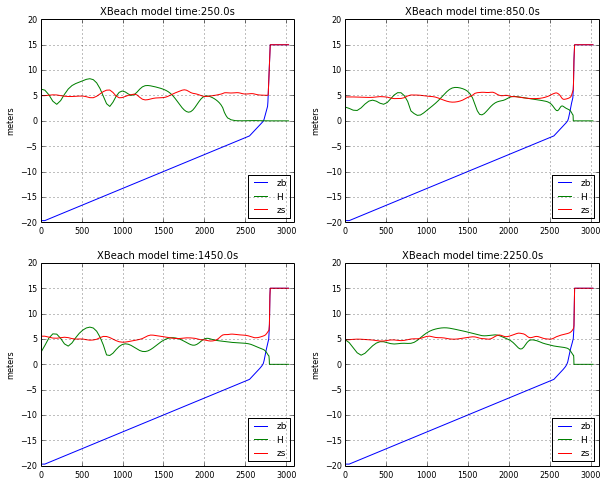

In [28]:
fig = plt.figure(figsize=(10,8), dpi=80) 
xbeach_frame(0,221)
xbeach_frame(600,222)
xbeach_frame(1200,223)
xbeach_frame(2000,224)

# Animation

Using IPython modules/libraries let's visualise the evolution through time:


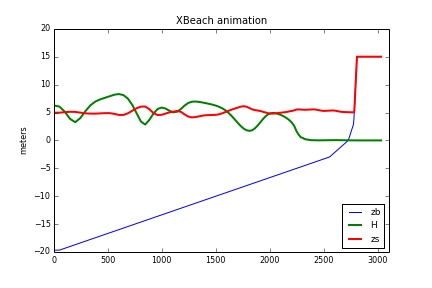
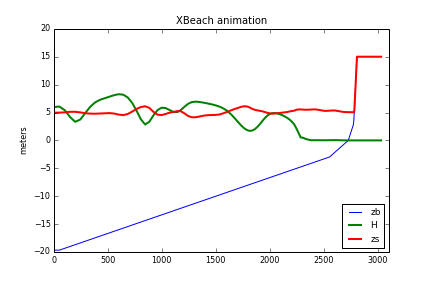
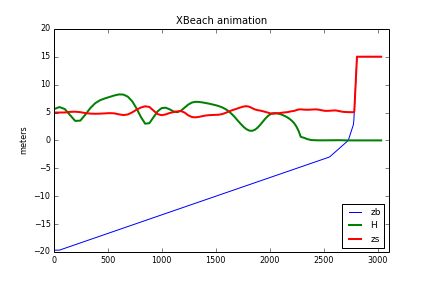
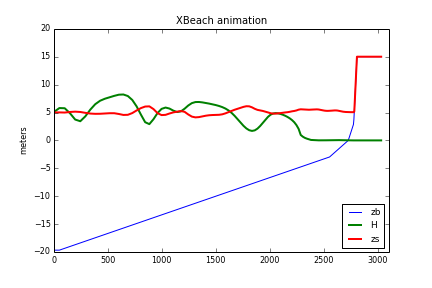
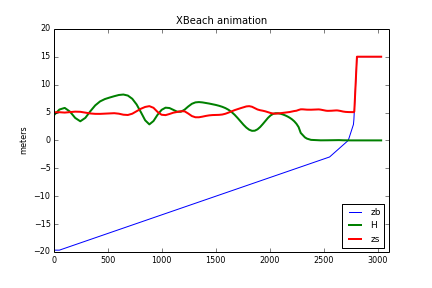
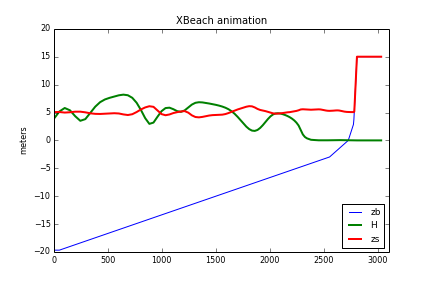
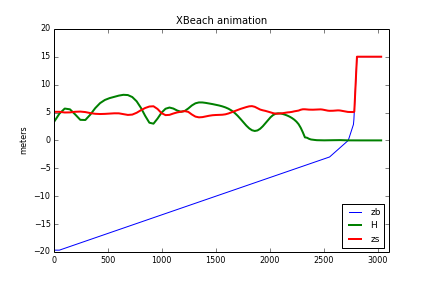
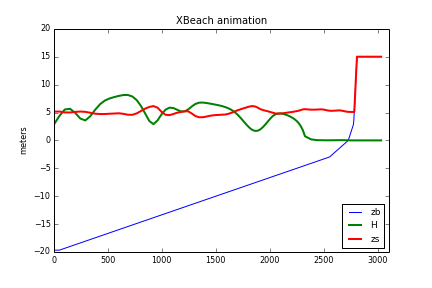
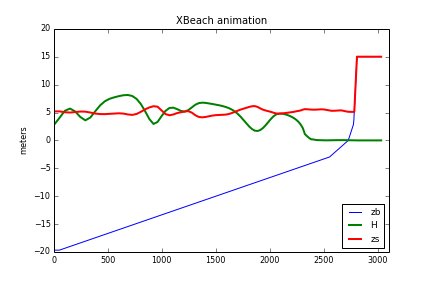
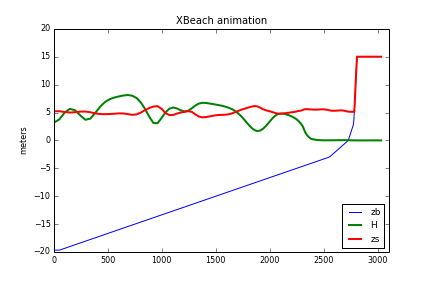
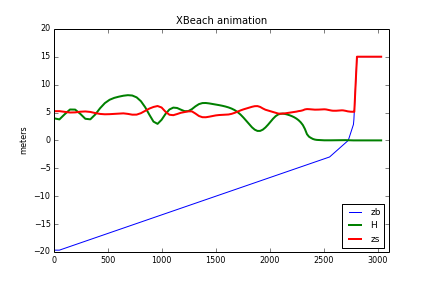
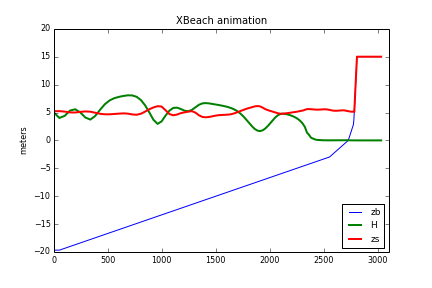
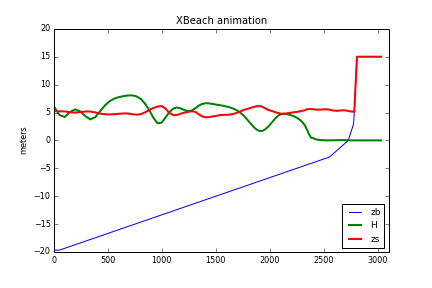
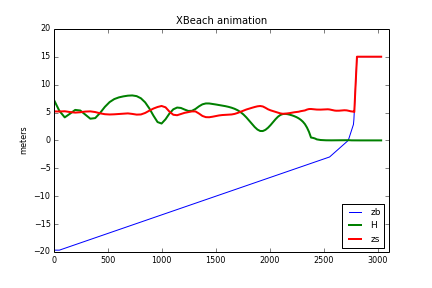
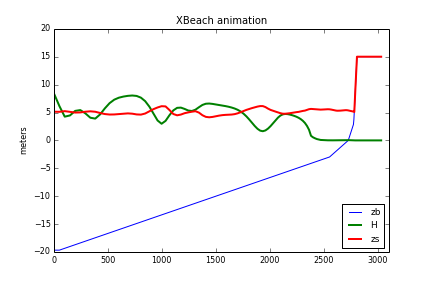
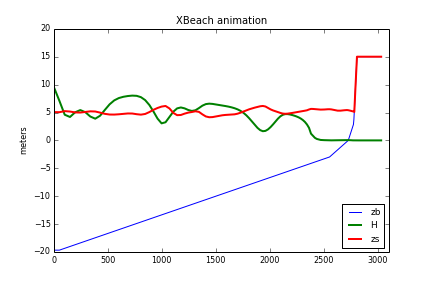
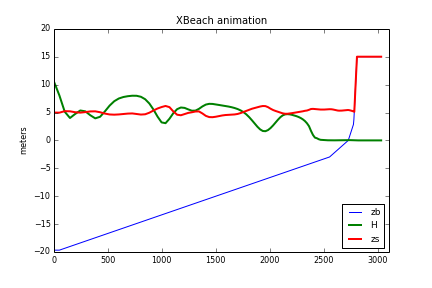
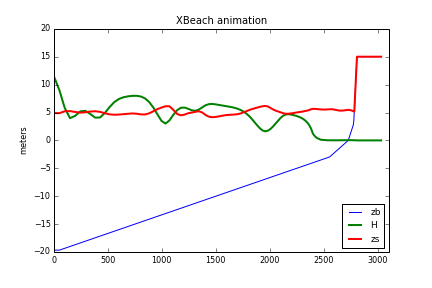
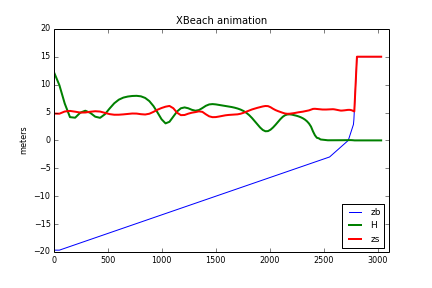
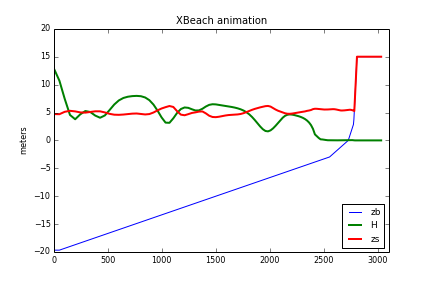
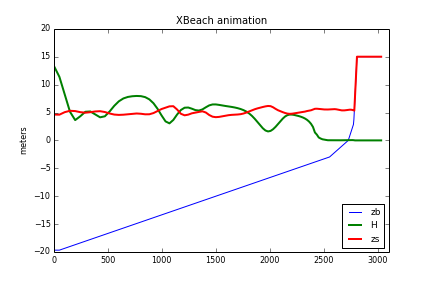
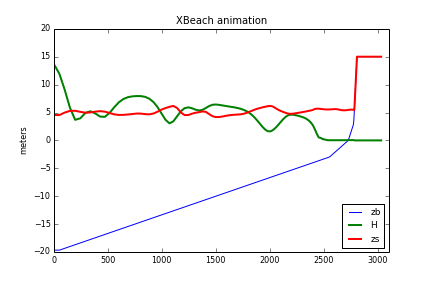
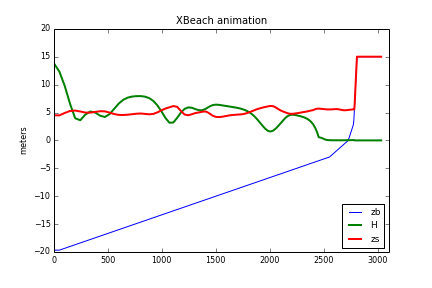
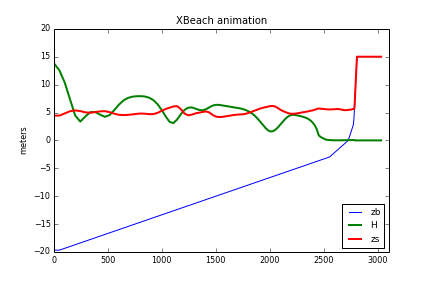
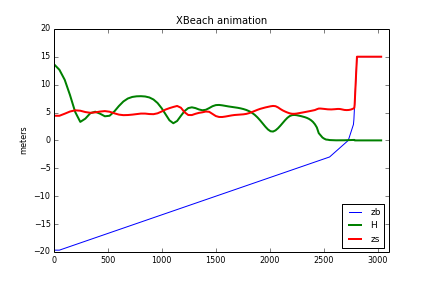
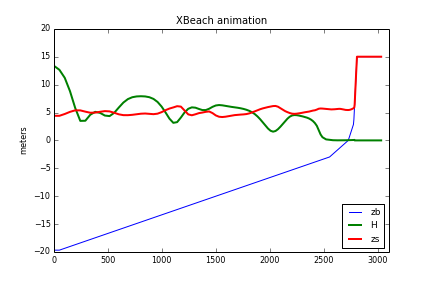
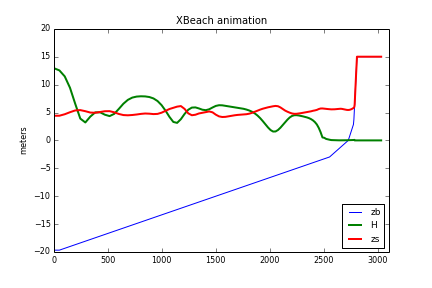
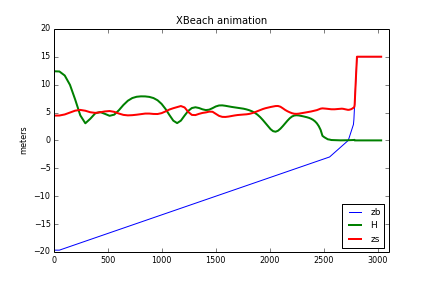
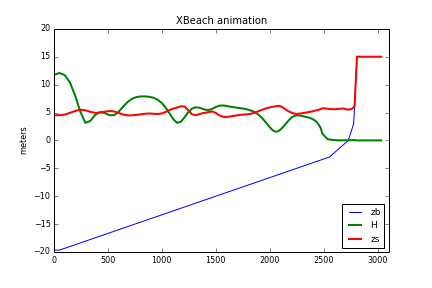
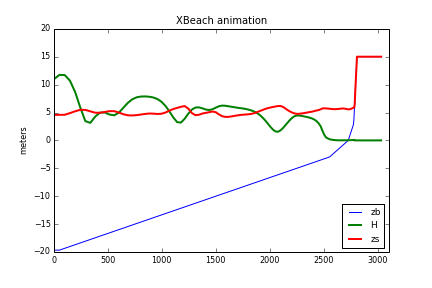
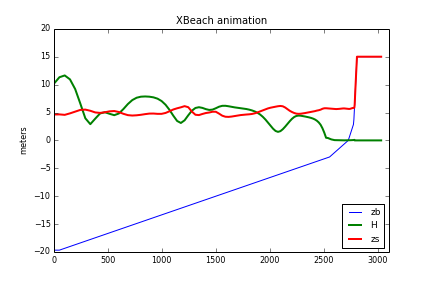
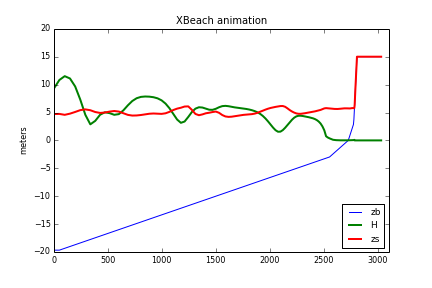
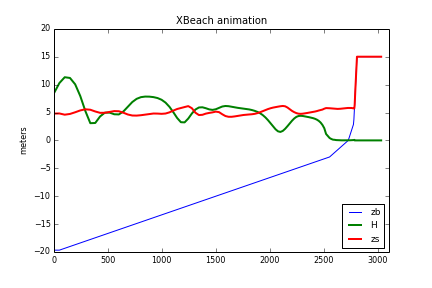
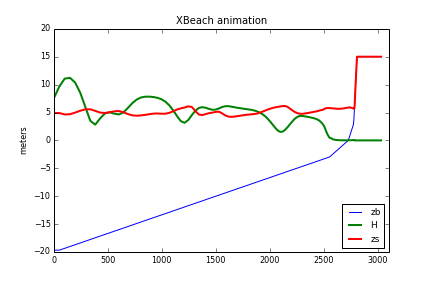
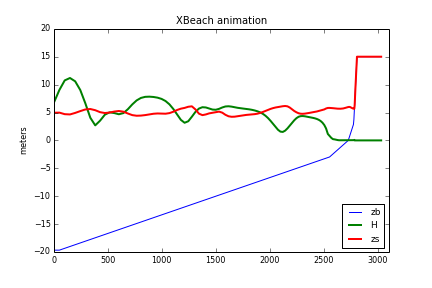
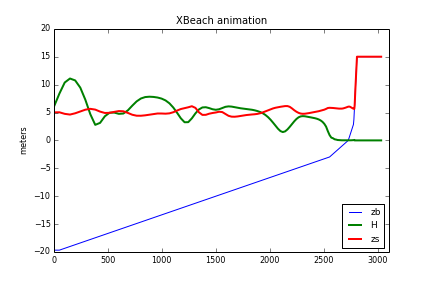
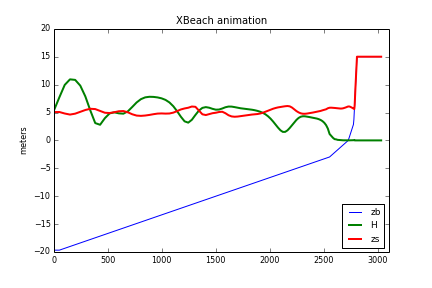
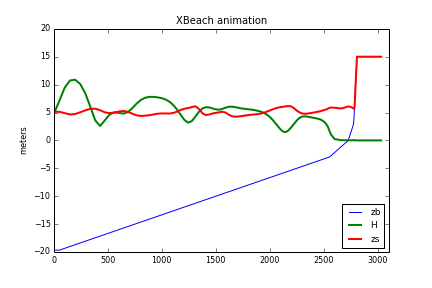
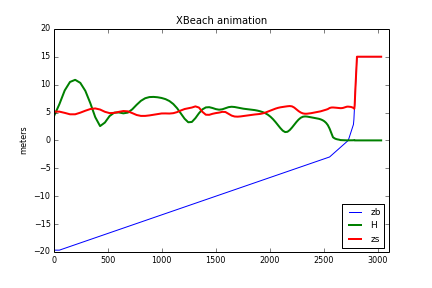
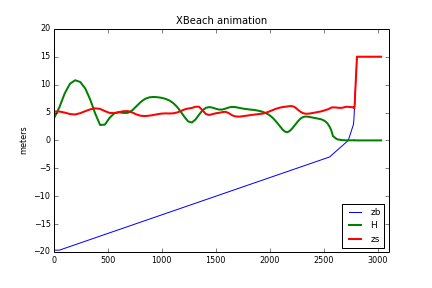
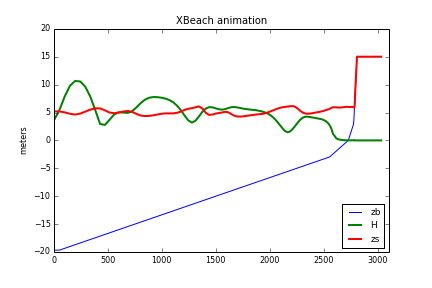
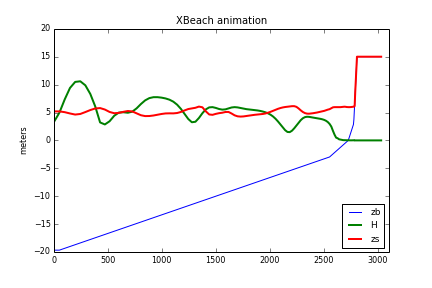
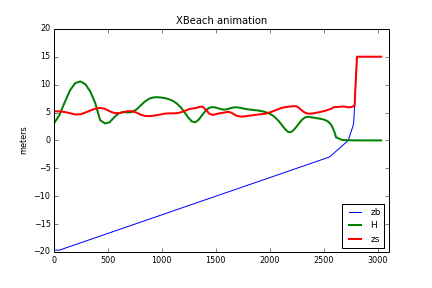
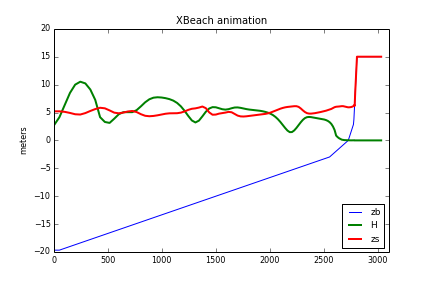
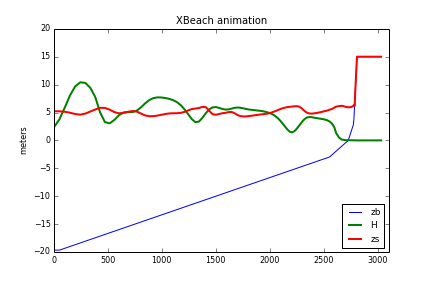
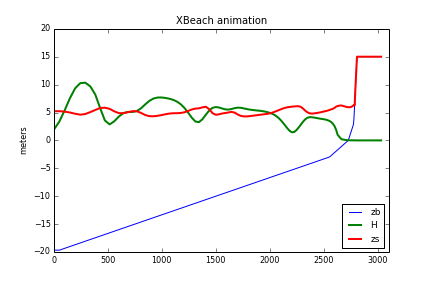
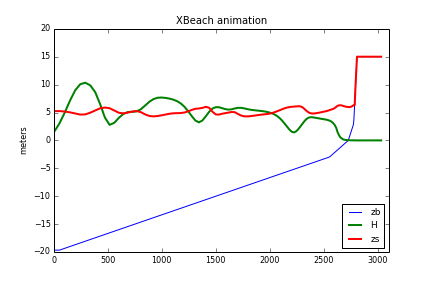
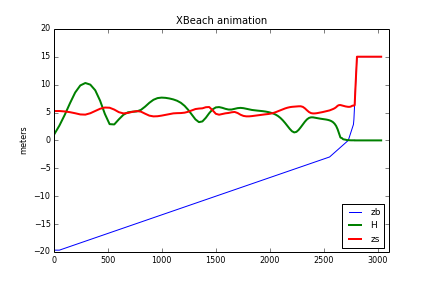
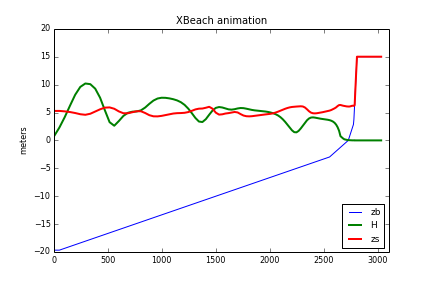
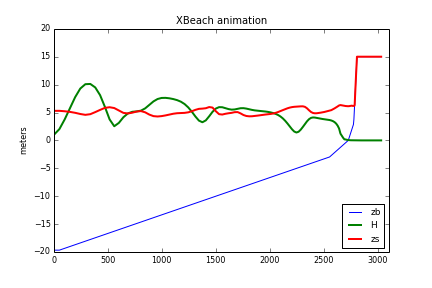
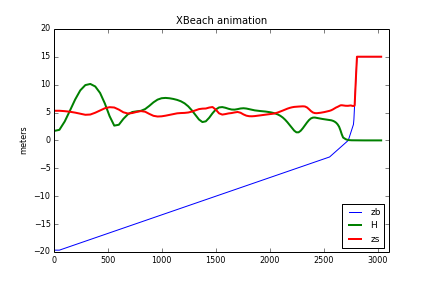
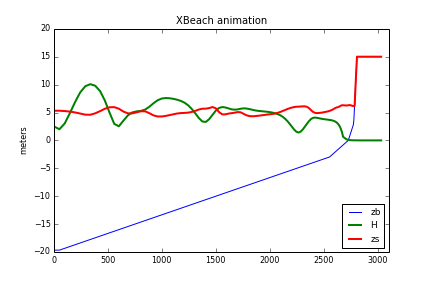
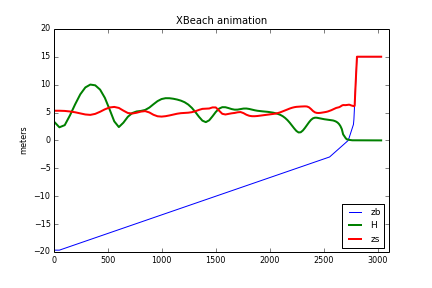
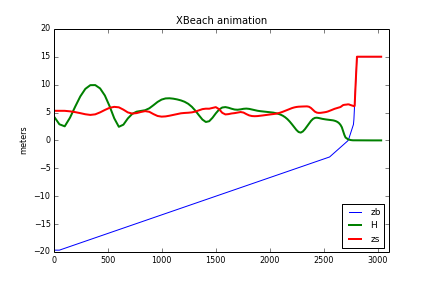
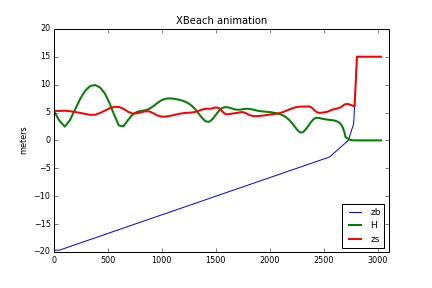
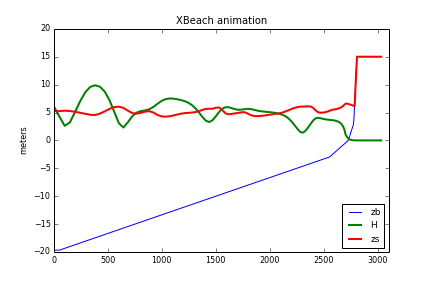
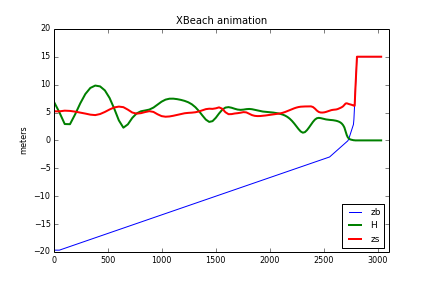
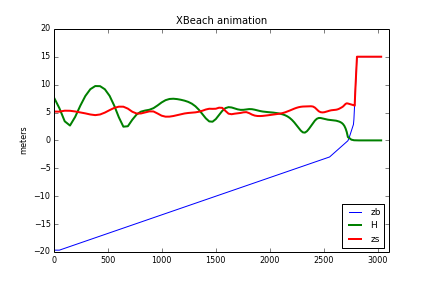
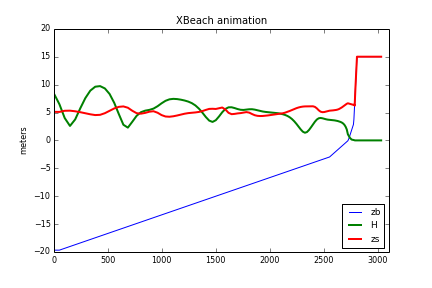
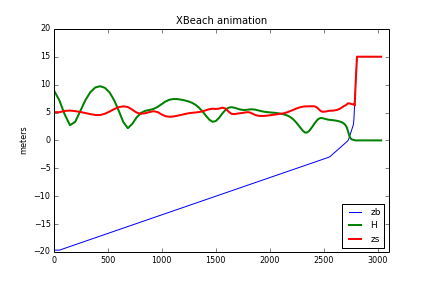
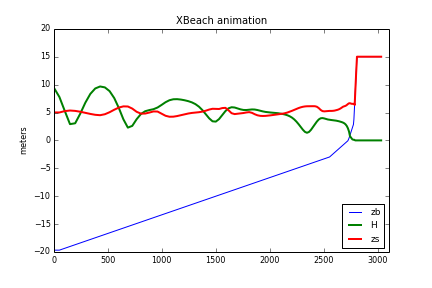
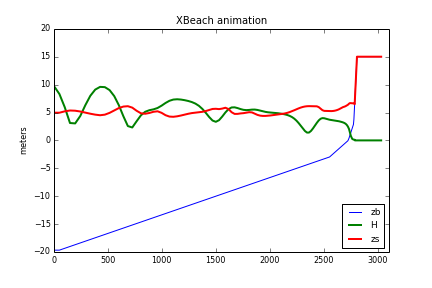
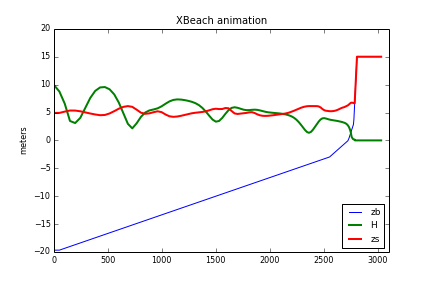
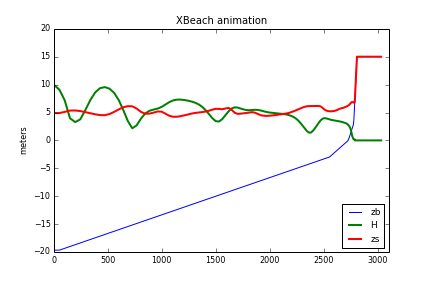
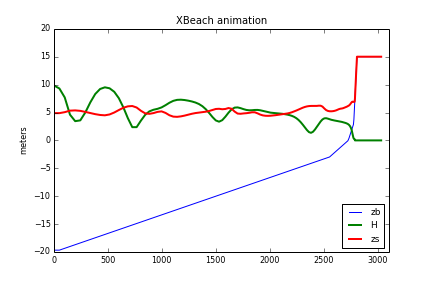
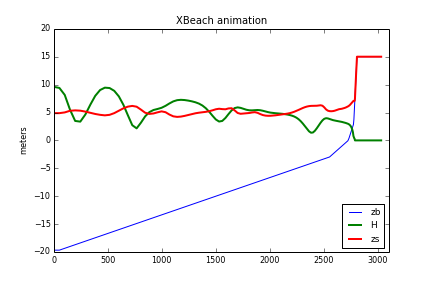
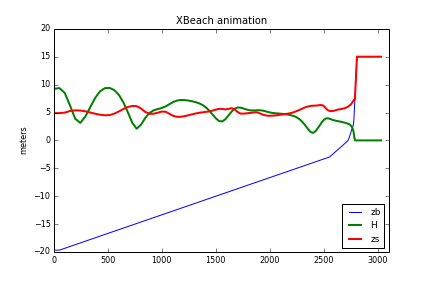
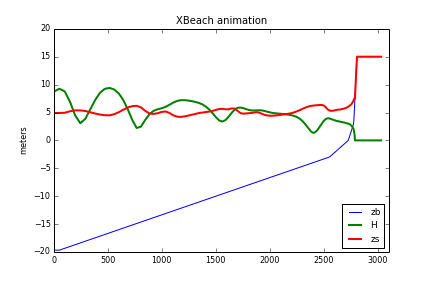
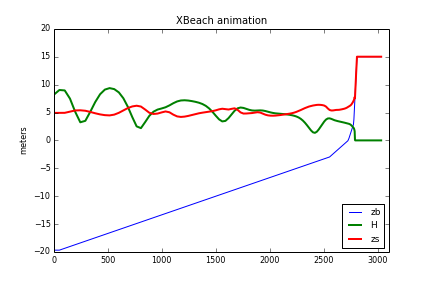
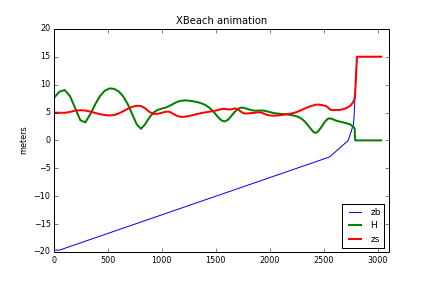
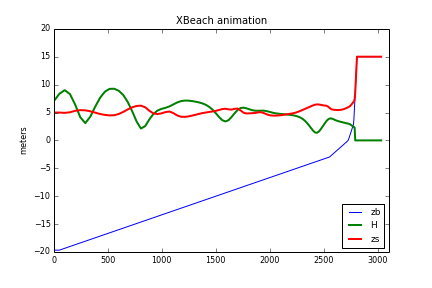
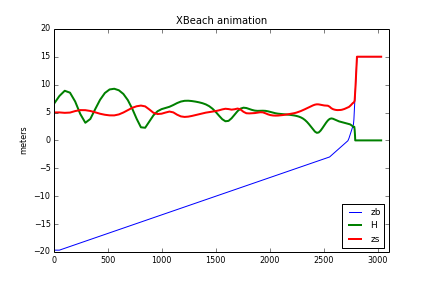
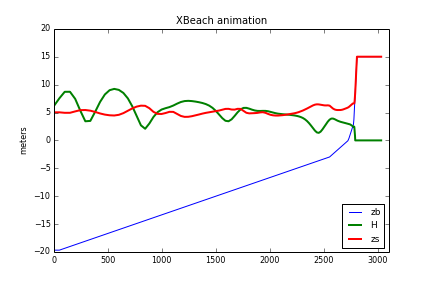
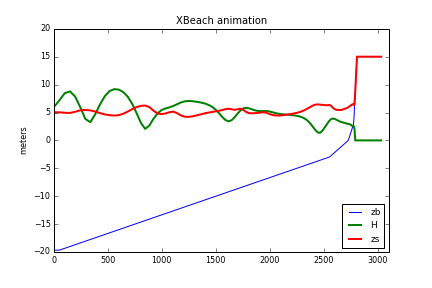
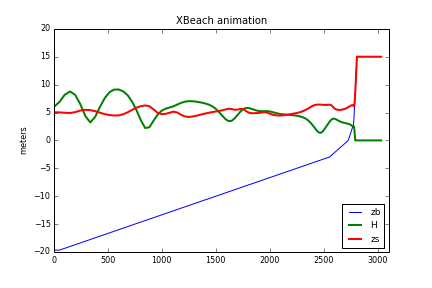
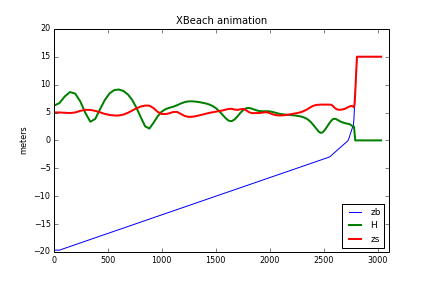
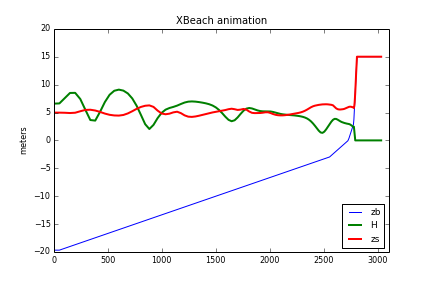
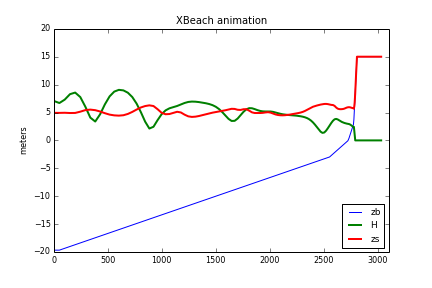
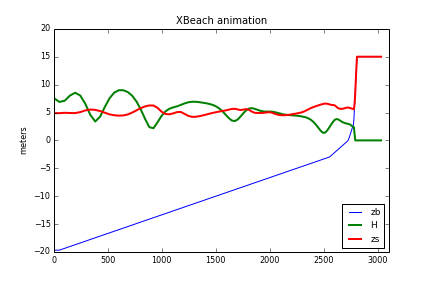
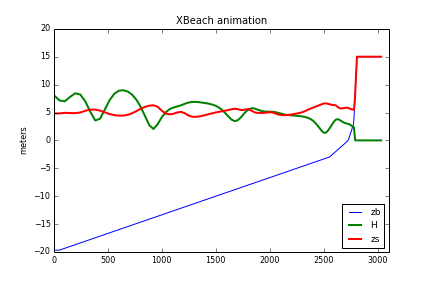
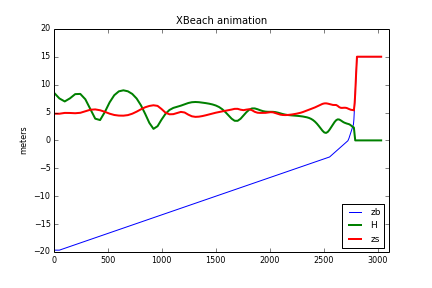
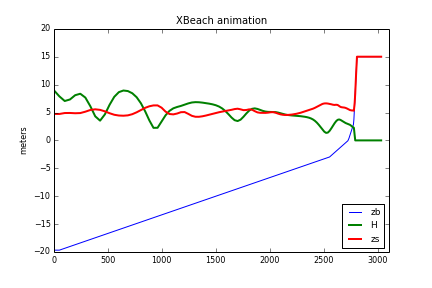
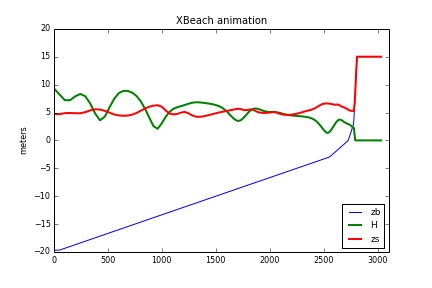
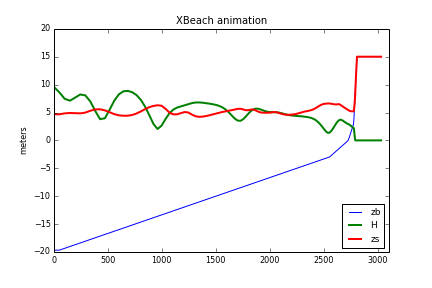
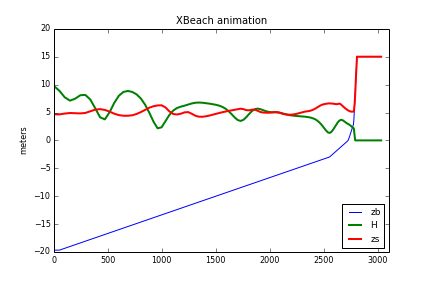
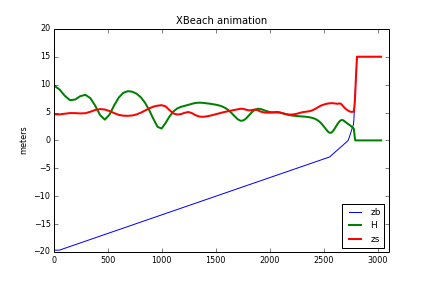
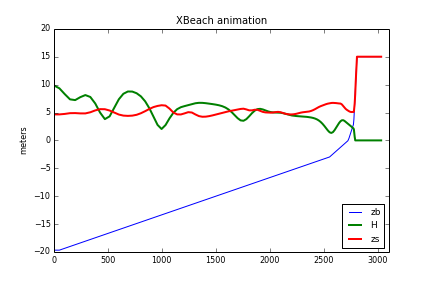
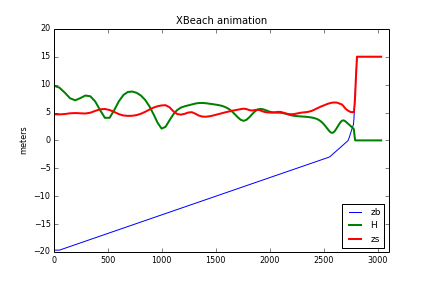
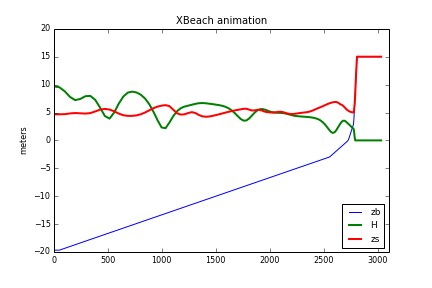
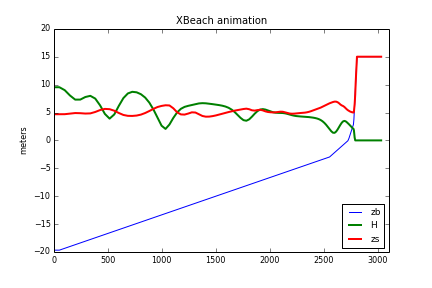
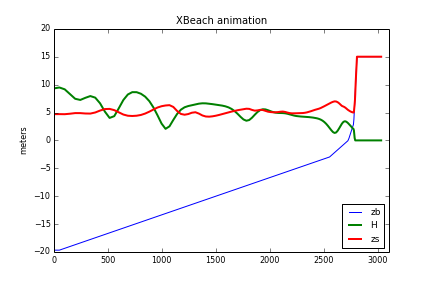
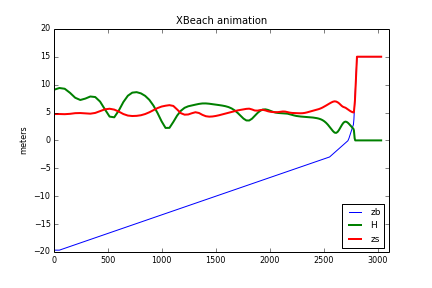
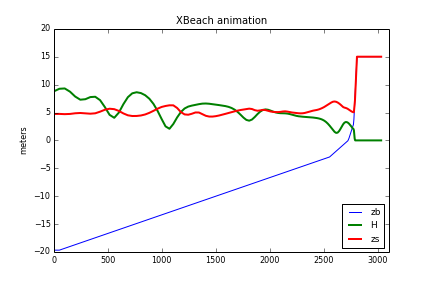
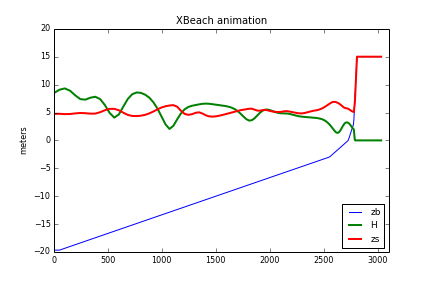
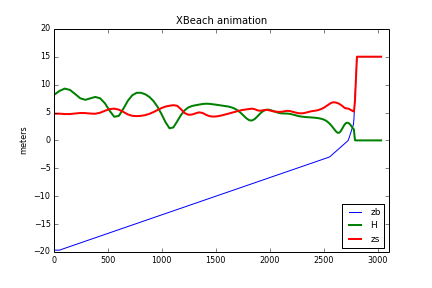
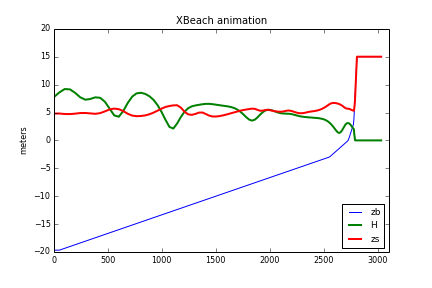
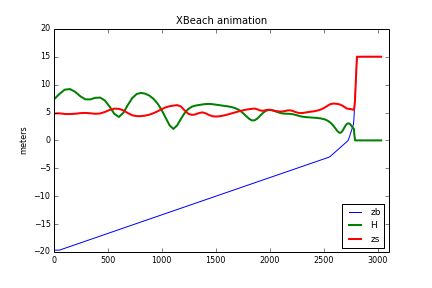
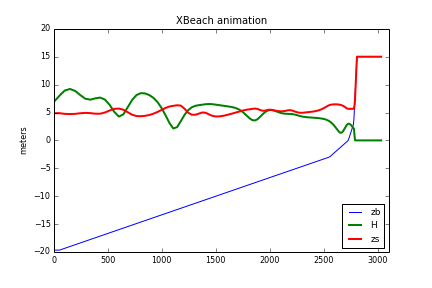
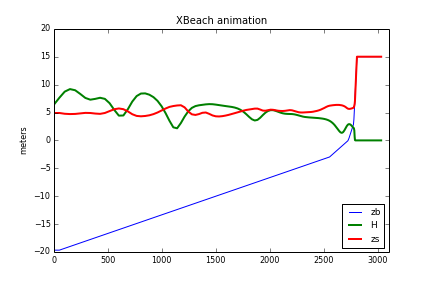
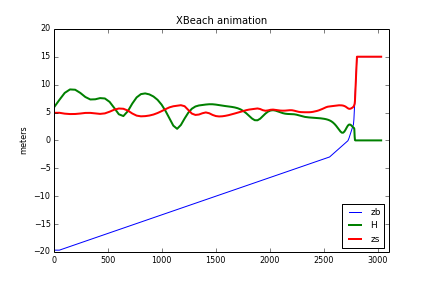
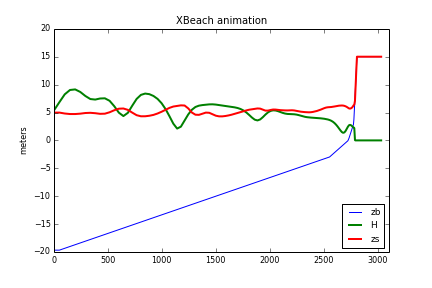
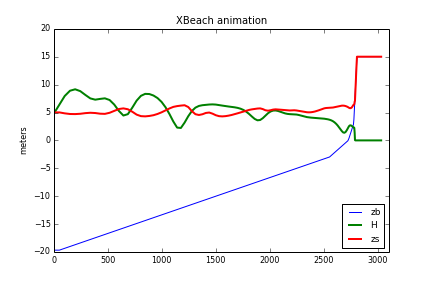
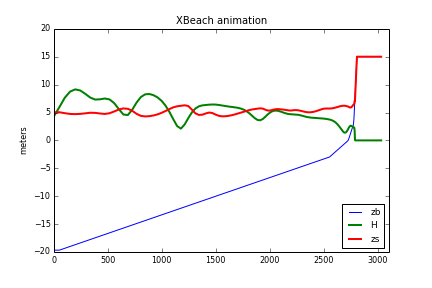
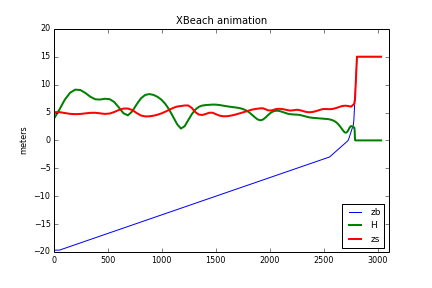
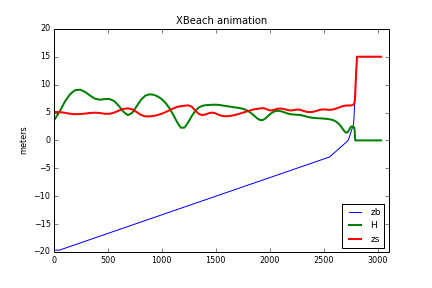
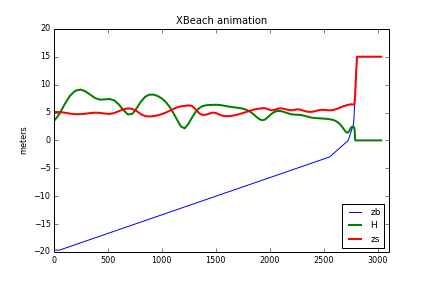
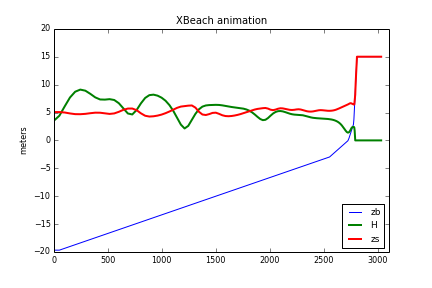
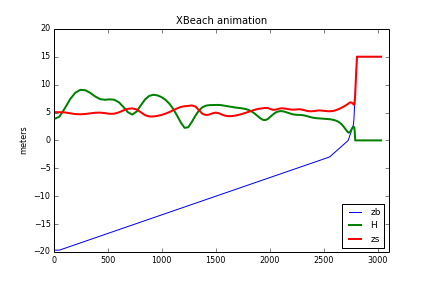
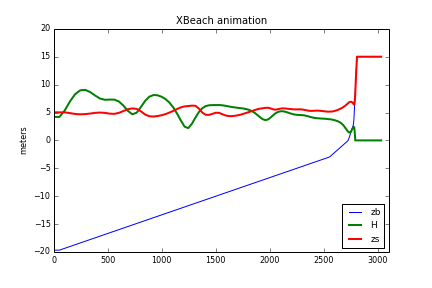
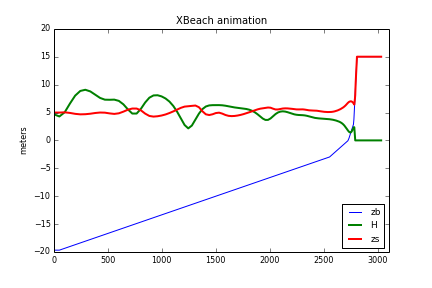
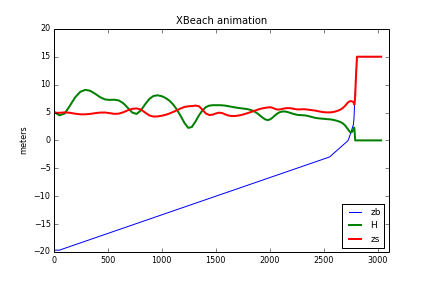
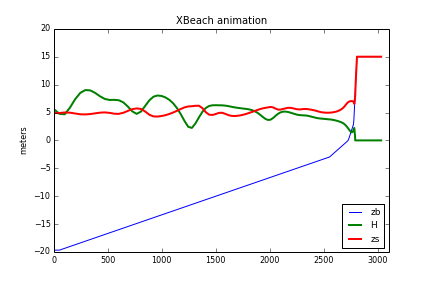
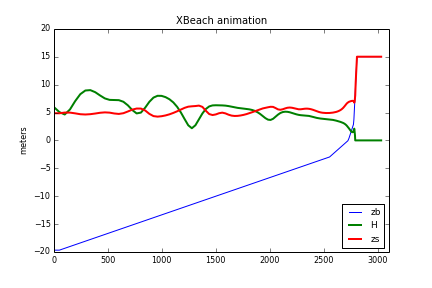
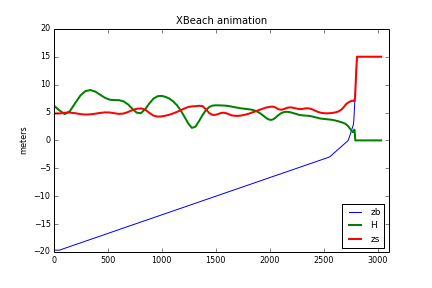
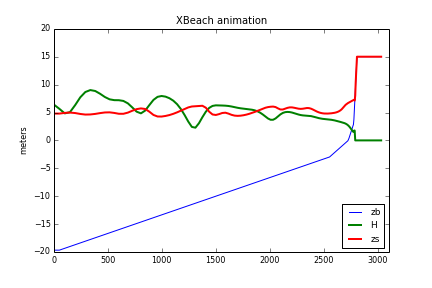
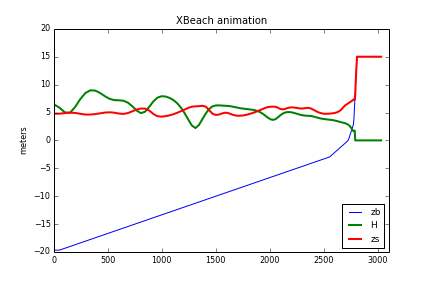
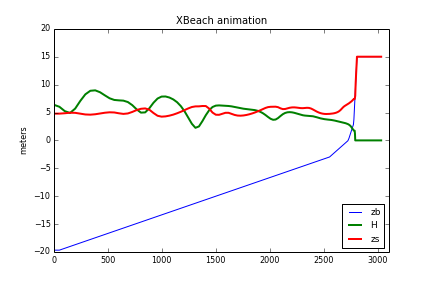
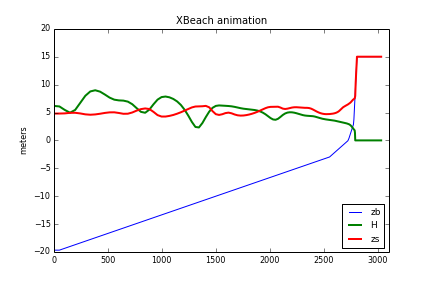
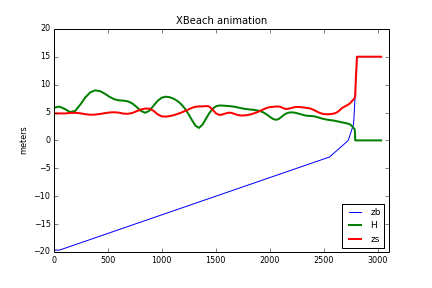
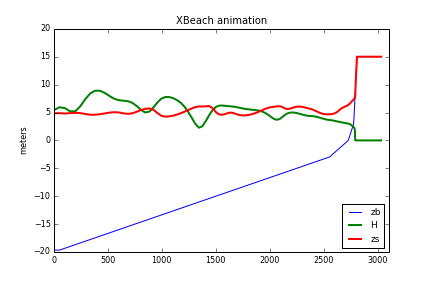
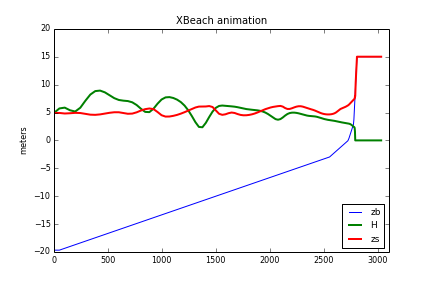
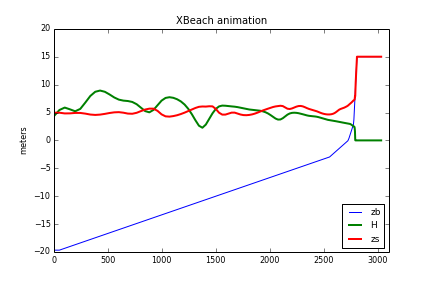
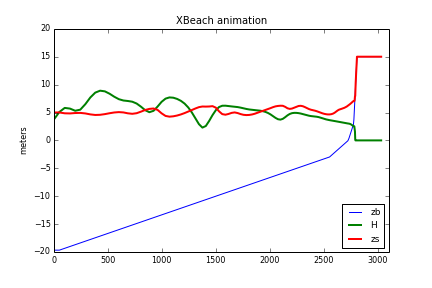
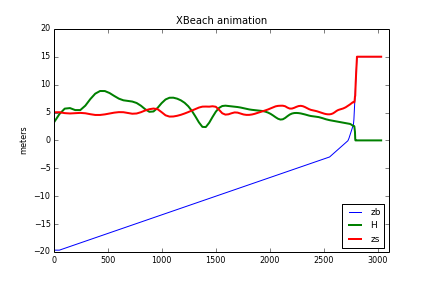
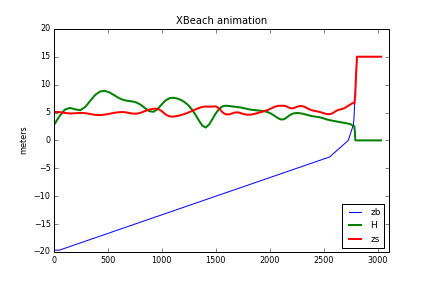
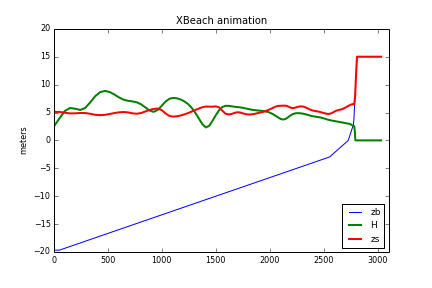
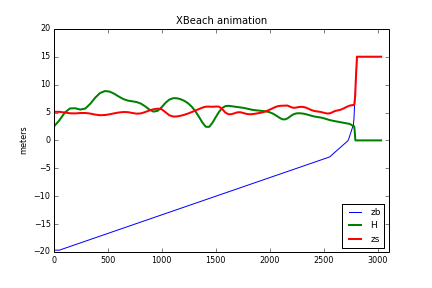
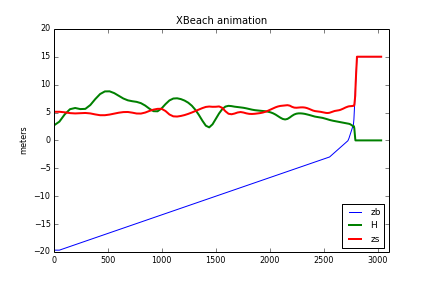
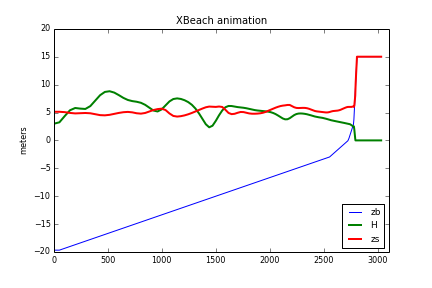
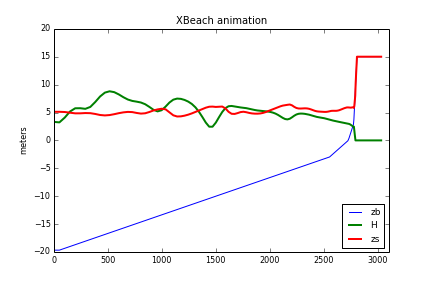
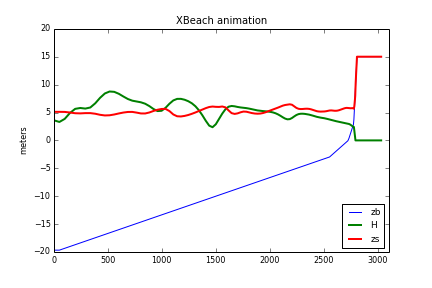
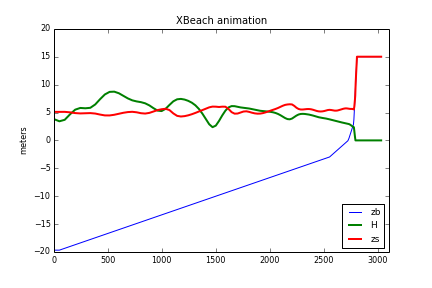
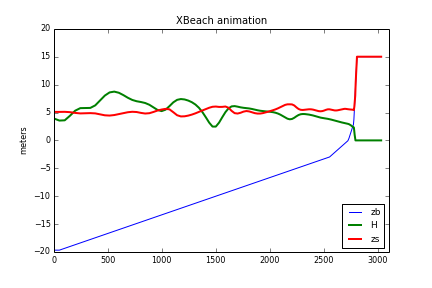
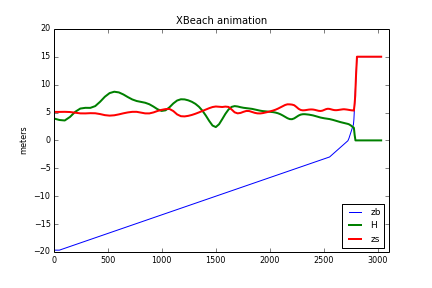
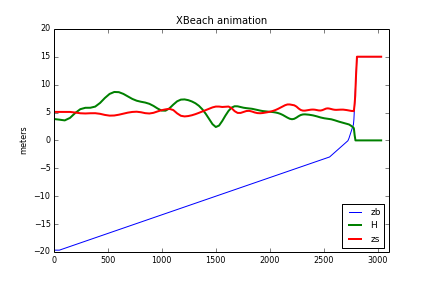
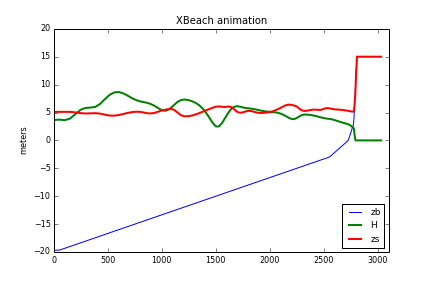
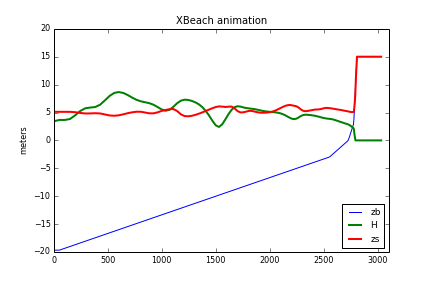
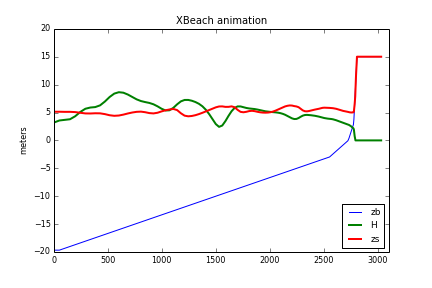
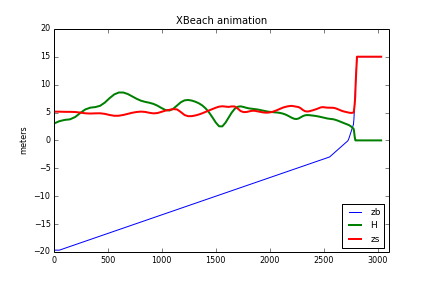
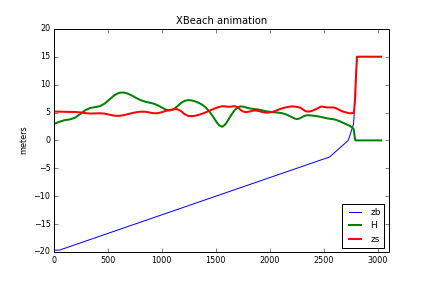
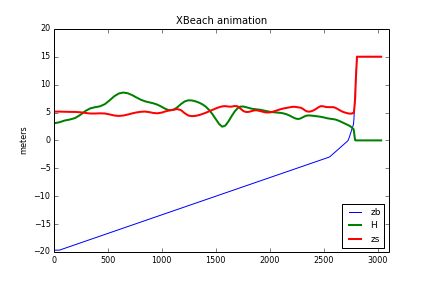
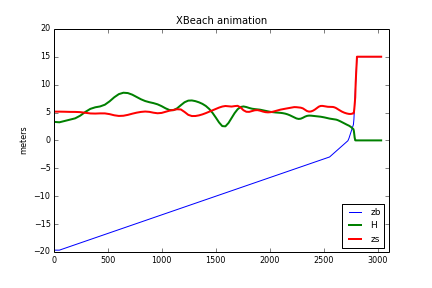
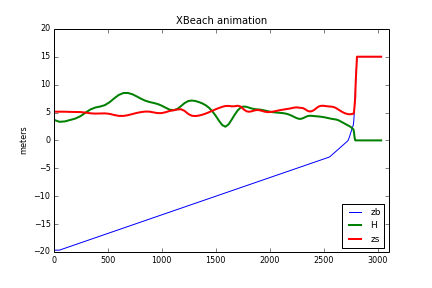
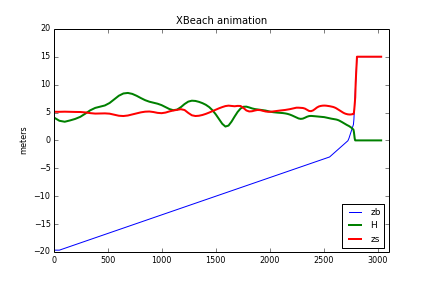
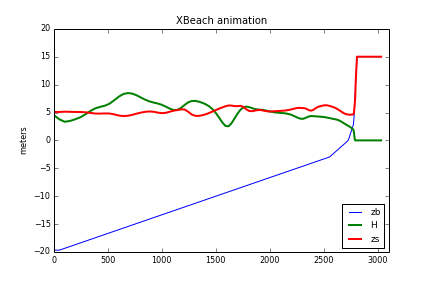
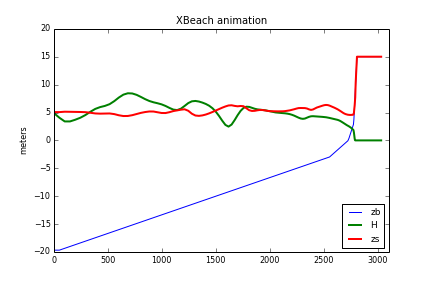
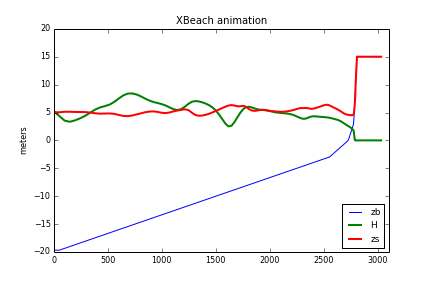
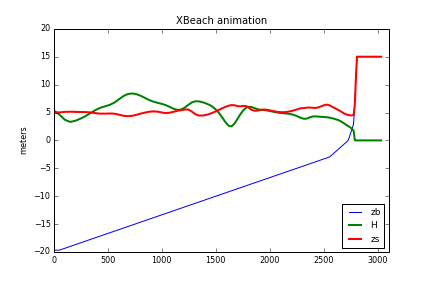
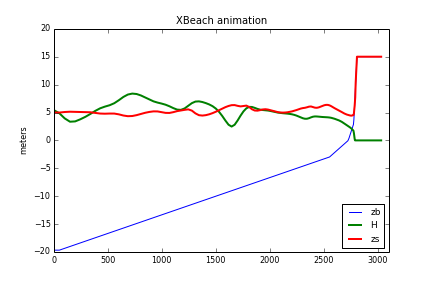
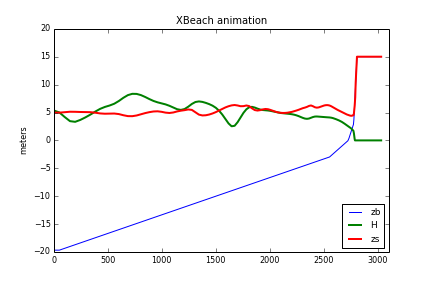
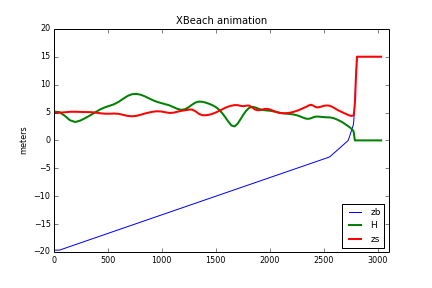
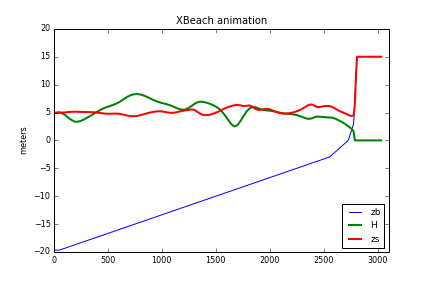
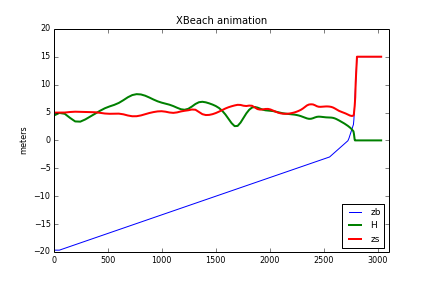
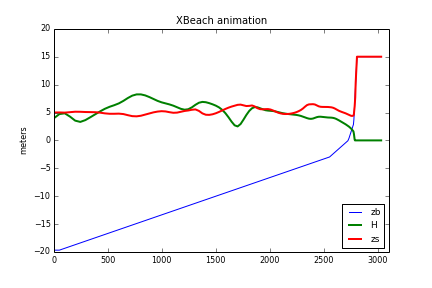
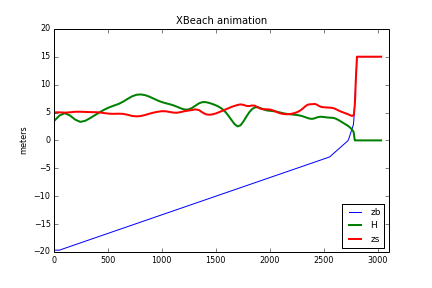
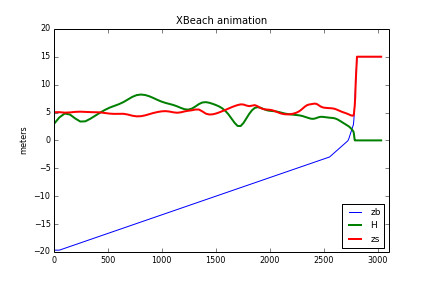
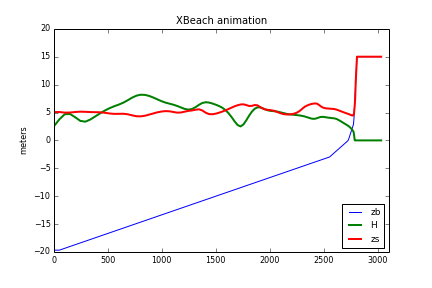
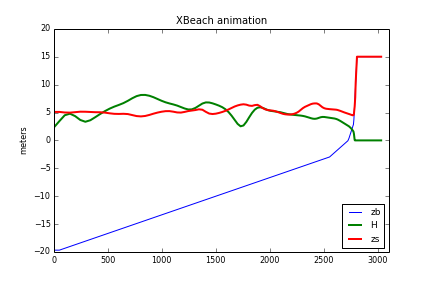
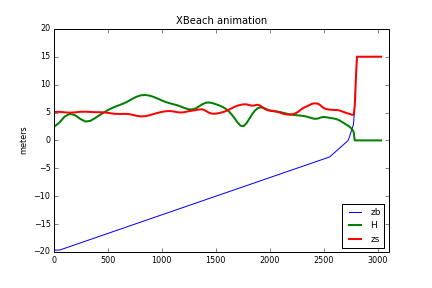
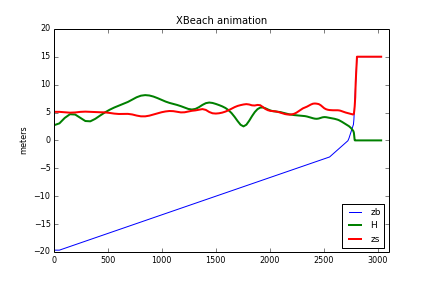
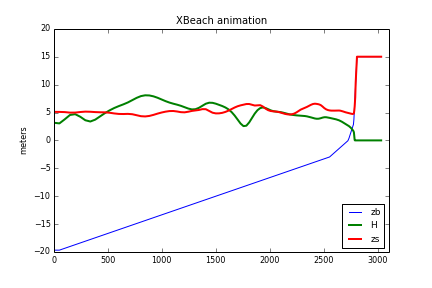
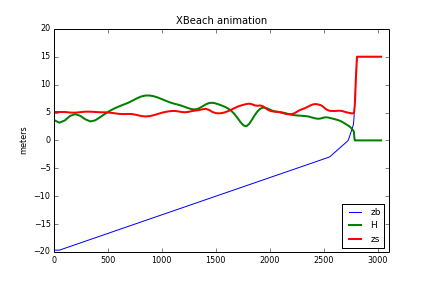
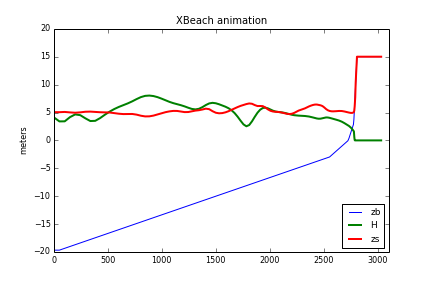
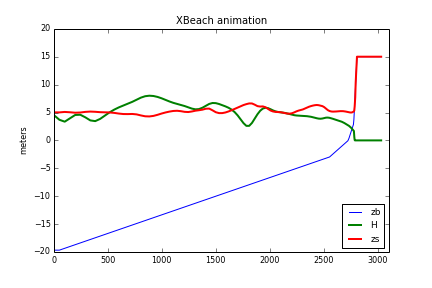
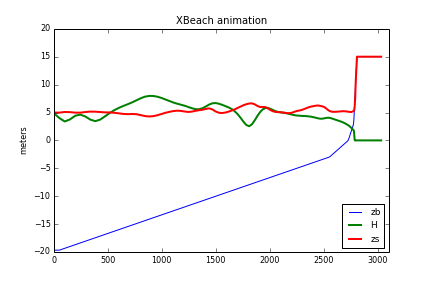
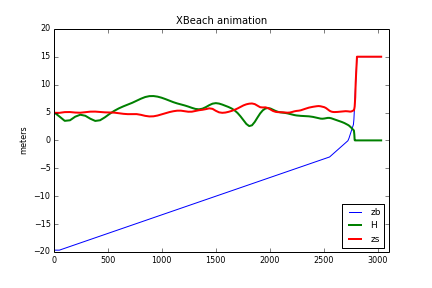
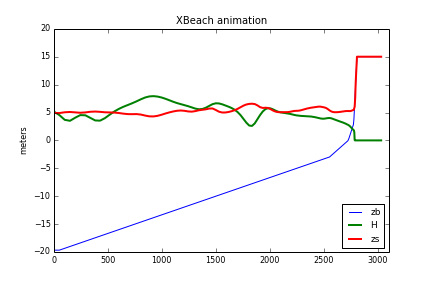
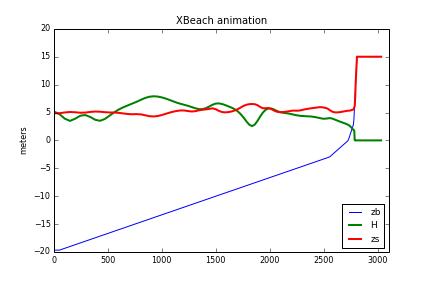
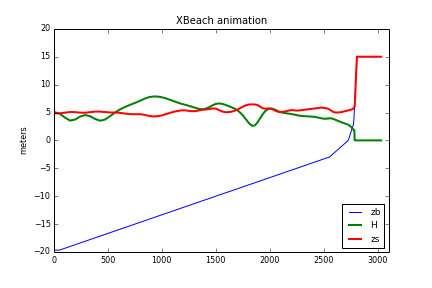
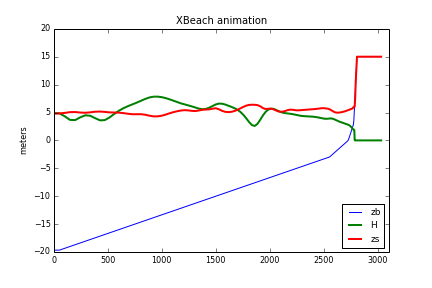
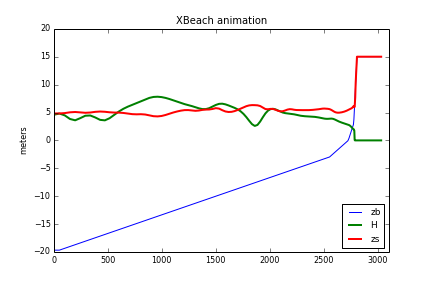
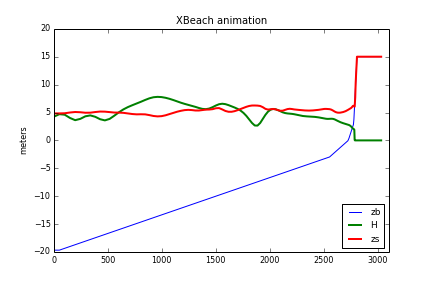
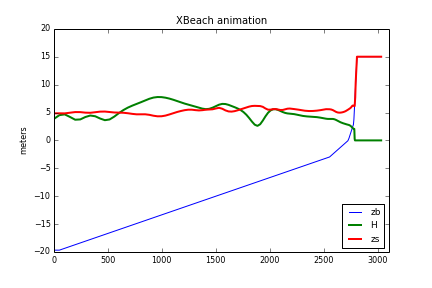
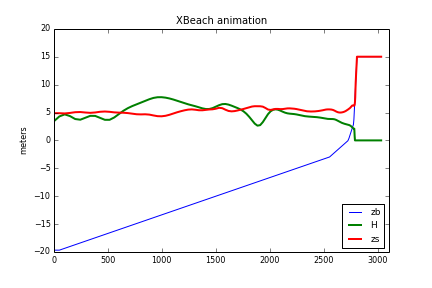
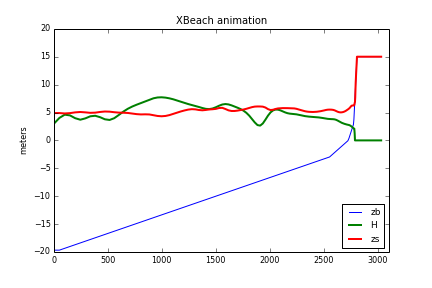
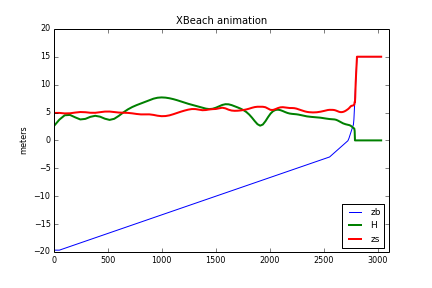
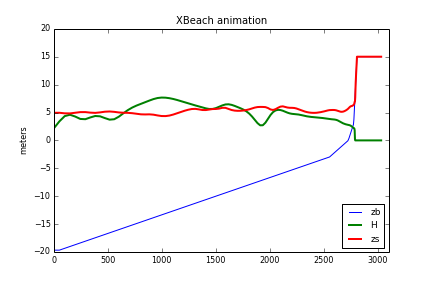
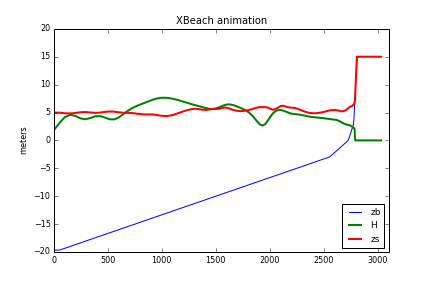
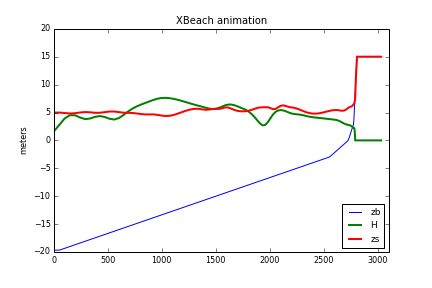
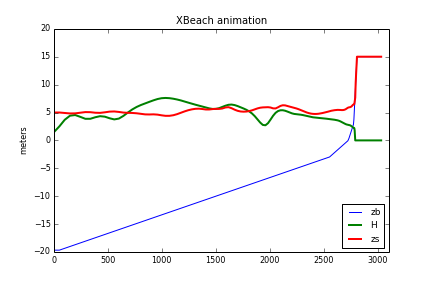
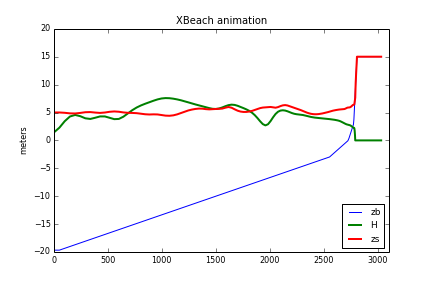
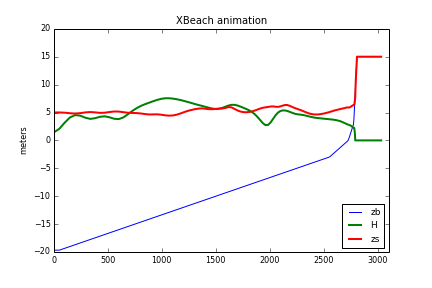
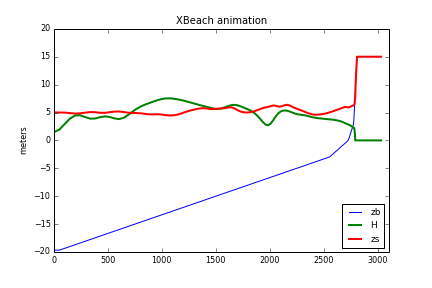
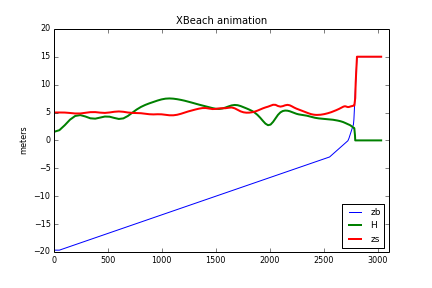
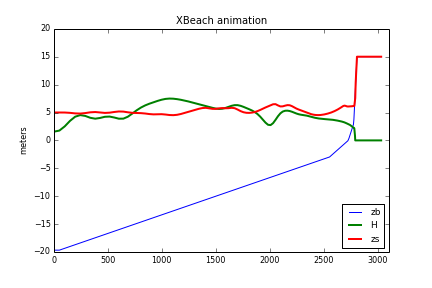
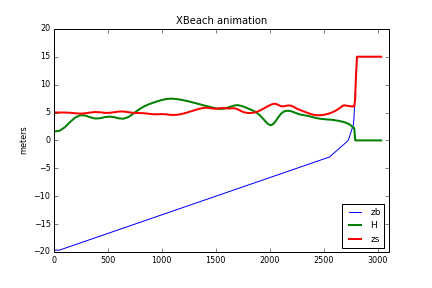
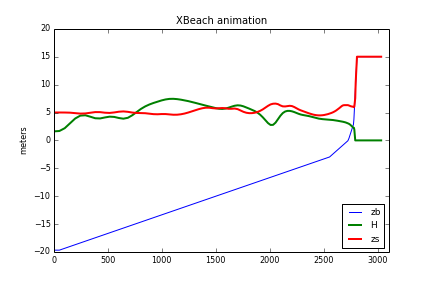
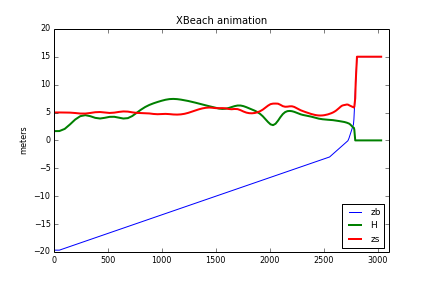
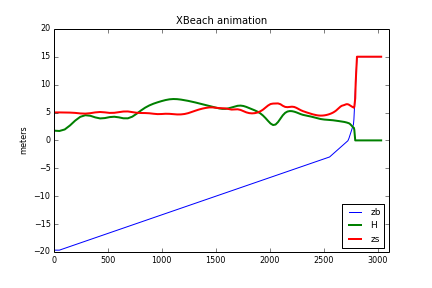
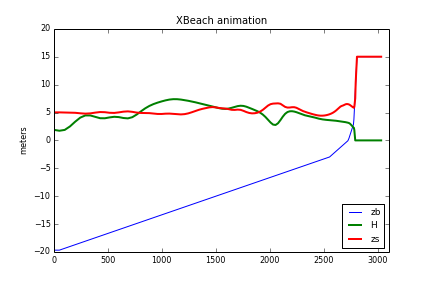
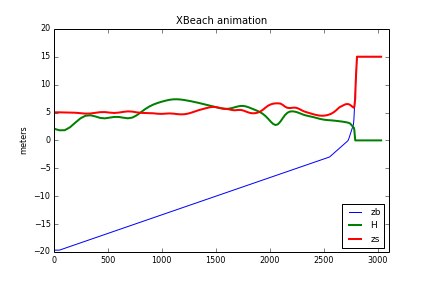
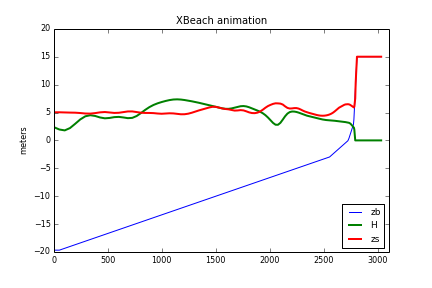
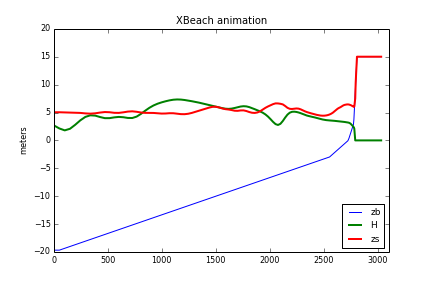
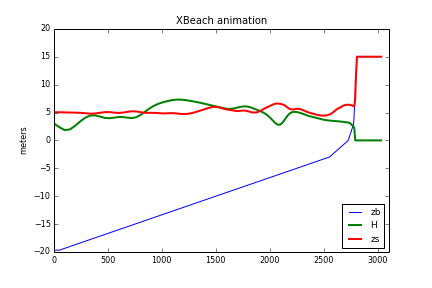
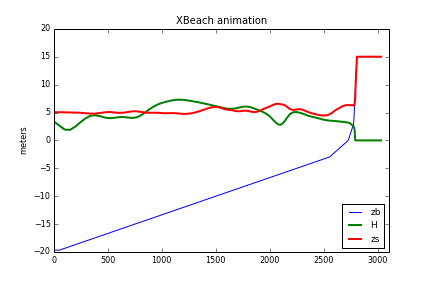
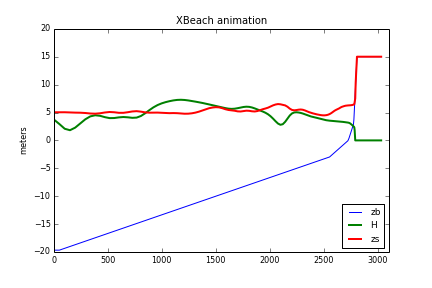
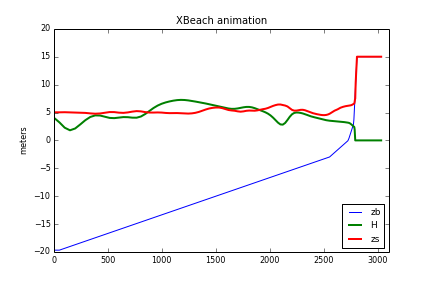
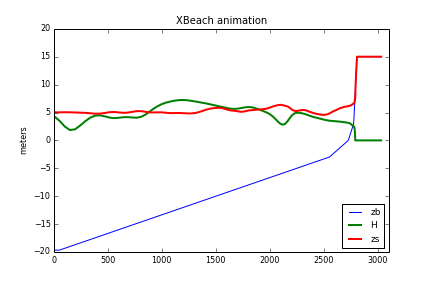
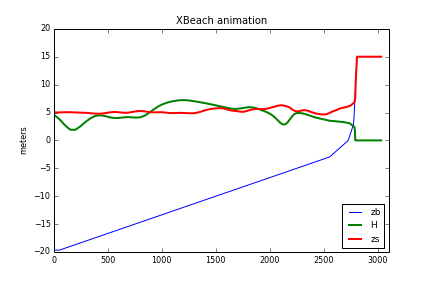
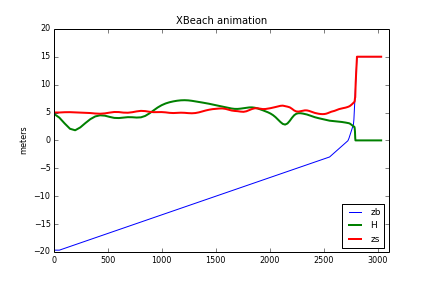

In [29]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes(xlim=(0, 3100), ylim=(-20, 20))
plt.title('XBeach animation', fontsize=10)
ax.set_ylabel('meters', fontsize=8)
plt.setp(ax.get_xticklabels(), fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
    

ax.plot(xprofile[:],bed_elev[0,:])

line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
#line3, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    #line3.set_data([], [])
    return line1,line2, #line3,

# animation function.  This is called sequentially
def animate(i):
    x = xprofile[:]
    f1 = wave_height[i,:]
    f2 = water_lvl[i,:]
    #f3 = bed_elev[i,:]
    line1.set_data(x, f1)
    line2.set_data(x, f2)
    #line3.set_data(x, f3)
    ax.legend(names,loc='lower right', fontsize=9)
    return line1,line2 #,line3

# call the animator.  blit=True means only re-draw the parts that have changed.
animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=30, blit=True)